In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import ValueWarning

In [34]:
CAMINHO_RAIZ = os.getcwd()
caminho_dados = os.path.join(CAMINHO_RAIZ, "data", "solar france.xlsx")

In [36]:
dataset = pd.read_excel(caminho_dados)
dataset["Date and Hour"] = pd.to_datetime(dataset["Date and Hour"])
dataset.set_index("Date and Hour", inplace=True)

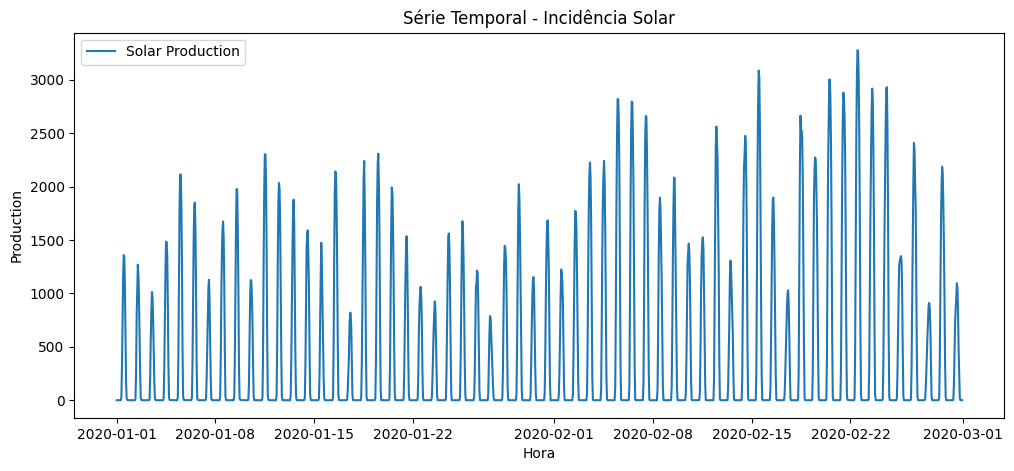

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(dataset.index, dataset["Production"], label="Solar Production")
plt.title("Série Temporal - Incidência Solar")
plt.xlabel("Hora")
plt.ylabel("Production")
plt.legend()
plt.show()

In [39]:
resultado_estacionariedade = adfuller(dataset["Production"])
print("Estatística ADF:", resultado_estacionariedade[0])
print("p-valor:", resultado_estacionariedade[1])

Estatística ADF: -5.242865426067968
p-valor: 7.1829410381196615e-06


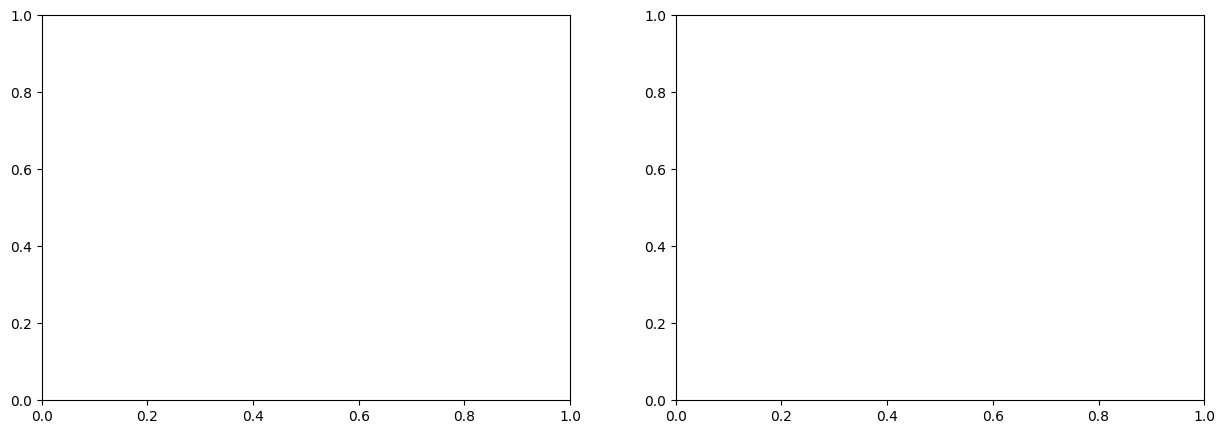

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

In [41]:
best_results = []
p_range = range(0, 4)
d = 0

q_range = range(0, 4)

P_range = range(0, 4)
D = 1
Q_range = range(0, 4)

s=52

In [42]:
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from joblib import Parallel, delayed
import itertools
import numpy as np
import pandas as pd

# >>> ENTRADAS
serie = dataset["Production"].astype(float)
s = 52  # sazonalidade já definida

# melhor atual (para gerar a vizinhança)
p0, d0, q0 = 1, 0, 3
P0, D0, Q0 = 1, 1, 3

# (opcional) usar subset rápido para busca; depois reestimar no full
use_subset = True
subset_len = 6 * s  # ~6 "estações"
y_fit = serie.iloc[-subset_len:] if (use_subset and len(serie) > subset_len) else serie

# Vizinhança: variar em torno do melhor (clamp em [0,4] para segurança)
def hood(v, lo=0, hi=4):
    return sorted(set([max(lo, min(hi, v + d)) for d in (-1, 0, 1)]))

p_grid  = hood(p0, 0, 4)
q_grid  = hood(q0, 0, 4)
P_grid  = hood(P0, 0, 3)
Q_grid  = hood(Q0, 0, 3)
d_grid  = sorted(set([d0, 1]))   # testa d igual ao atual e +1
D_grid  = [D0]                    # mantém D=1
lb_lags = [10, 15, 20]

# heurística simples para evitar modelos "pesados" sem necessidade
def skip(p,q,P,Q):
    if (p+q) > 5: return True
    if (P+Q) > 4: return True
    if p>=3 and q>=3: return True
    if P>=2 and Q>=2: return True
    return False

def eval_model(order, seasonal_order):
    try:
        p,d,q = order
        P,D,Q,s = seasonal_order

        # acelera o ajuste
        model = SARIMAX(
            y_fit,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
            simple_differencing=True,    # costuma acelerar
            concentrate_scale=True
        )
        res = model.fit(disp=False, method="lbfgs", maxiter=150, tol=1e-4)

        # Ljung-Box nos resíduos
        lb = acorr_ljungbox(res.resid, lags=lb_lags, return_df=True)
        lb_pmin = float(lb["lb_pvalue"].min())
        lb_stats = {f"LB_p@{L}": float(lb.loc[L, "lb_pvalue"]) for L in lb_lags}

        return {
            "order": order,
            "seasonal": seasonal_order,
            "aic": float(res.aic),
            "bic": float(res.bic),
            "lb_pmin": lb_pmin,
            **lb_stats
        }
    except Exception as e:
        return None

# gerar candidatos
candidatos = []
for p,q,P,Q,d,D in itertools.product(p_grid, q_grid, P_grid, Q_grid, d_grid, D_grid):
    if skip(p,q,P,Q):
        continue
    # evita redundâncias óbvias: se d=1 e p e q são altos, costuma sobrar correlação
    if d==1 and (p+q)>=6:
        continue
    candidatos.append(((p,d,q),(P,D,Q,s)))

# avaliar em paralelo
best_results = Parallel(n_jobs=-1, verbose=10)(
    delayed(eval_model)(o, so) for (o,so) in candidatos
)

# filtra falhas
best_results = [r for r in best_results if r is not None]

# rank: maior lb_pmin (melhor ruído branco), depois menor AIC
df = pd.DataFrame(best_results)
df = df.sort_values(by=["lb_pmin","aic"], ascending=[False, True]).reset_index(drop=True)

print("\n=== TOP 10 por (Ljung-Box p-min DESC, AIC ASC) ===")
cols_show = ["order","seasonal","aic","bic","lb_pmin"] + [f"LB_p@{L}" for L in lb_lags]
print(df[cols_show].head(10).to_string(index=False))

# reestimar o melhor no FULL para métricas finais
if not df.empty:
    best = df.iloc[0]
    best_order = tuple(best["order"])
    best_seasonal = tuple(best["seasonal"])
    final = SARIMAX(
        serie,
        order=best_order,
        seasonal_order=best_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
        simple_differencing=True,
        concentrate_scale=True
    ).fit(disp=False, method="lbfgs", maxiter=300, tol=1e-5)

    print("\n=== Melhor reestimado na série completa ===")
    print(f"order={best_order}, seasonal={best_seasonal}")
    print(f"AIC={final.aic:.1f} | BIC={final.bic:.1f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  48 out of  64 | elapsed:  3.9min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  55 out of  64 | elapsed:  4.3min remaining:   42.1s
[Parallel(n_jobs=-1)]: Done  62 out of  64 | elapsed:  5.0min remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  5.3min finished
C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pg


=== TOP 10 por (Ljung-Box p-min DESC, AIC ASC) ===
    order      seasonal         aic         bic      lb_pmin      LB_p@10      LB_p@15      LB_p@20
(2, 0, 2) (0, 1, 2, 52) 2001.259808 2022.472873 3.412421e-06 5.022513e-06 2.285541e-05 3.412421e-06
(2, 1, 2) (0, 1, 2, 52) 1991.525685 2012.692849 3.682331e-07 2.397589e-06 1.360404e-06 3.682331e-07
(2, 1, 3) (0, 1, 2, 52) 1979.013553 2003.151791 2.641393e-07 1.534954e-06 1.026826e-06 2.641393e-07
(2, 0, 2) (1, 1, 2, 52) 1999.168837 2023.412340 1.954095e-07 6.357317e-07 2.750156e-06 1.954095e-07
(2, 1, 3) (0, 1, 3, 52) 1300.733957 1324.090035 8.653416e-08 8.653416e-08 1.332617e-07 1.102947e-07
(2, 1, 2) (0, 1, 3, 52) 1312.235326 1333.076687 4.056974e-08 4.357790e-08 5.685128e-08 4.056974e-08
(2, 1, 3) (1, 1, 2, 52) 1977.659353 2004.814872 2.158685e-08 2.650105e-07 9.650106e-08 2.158685e-08
(2, 1, 2) (1, 1, 2, 52) 1989.161714 2013.352758 1.581181e-08 2.440979e-07 7.340962e-08 1.581181e-08
(2, 0, 3) (0, 1, 2, 52) 1987.373916 2011.564960 

In [45]:
def get_best_index(results, key="aic"):
    """
    Retorna o índice do melhor modelo com base no menor valor de AIC (ou outra métrica).

    :param results: lista de dicionários com os resultados dos modelos
    :param key: métrica usada para escolher o melhor (default = 'aic')
    :return: índice do melhor modelo
    """
    valores = [item[key] for item in results]
    melhor_index = min(range(len(valores)), key=lambda i: valores[i])
    return melhor_index

In [46]:
i = get_best_index(best_results)
print(i)

63


In [49]:
# Extrair apenas os 4 valores da tupla (sem o modelo em si)
i = get_best_index(best_results)
print(best_results[i])
best_order, best_seas, best_aic, best_bic = best_results[i]['order'], best_results[i]['seasonal'], best_results[i]['aic'], best_results[i]['bic']
# Separar em variáveis individuais
print (best_order)
p, d_best, q = best_order
P, D_best, Q, s_best = best_seas

print("=== Melhor modelo por AIC ===")
print(f"p={p}, d={d_best}, q={q}, P={P}, D={D_best}, Q={Q}, s={s_best}")
print(f"AIC={best_aic:.2f}, BIC={best_bic:.2f}")

# Reestimar o melhor modelo na série completa
final_model = SARIMAX(
    serie,
    order=best_order,
    seasonal_order=best_seas,
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=True,
    concentrate_scale=True
).fit(disp=False, method="lbfgs", maxiter=300, tol=1e-5)

print("\n=== Usando o modelo final já treinado ===")
best_model = final_model  # esse é o que você deve usar adiante
print(best_model.summary())

{'order': (2, 1, 3), 'seasonal': (1, 1, 3, 52), 'aic': 1295.4350957057854, 'bic': 1321.3862942071314, 'lb_pmin': 9.565815538301246e-12, 'LB_p@10': 8.125177253599746e-11, 'LB_p@15': 1.743986434579803e-11, 'LB_p@20': 9.565815538301246e-12}
(2, 1, 3)
=== Melhor modelo por AIC ===
p=2, d=1, q=3, P=1, D=1, Q=3, s=52
AIC=1295.44, BIC=1321.39


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


KeyboardInterrupt: 

In [28]:
# 'best_model' já é o objeto resultante (.fit()) do melhor ajuste
print(best_model.summary())  # resumo estatístico do ajuste

                                         SARIMAX Results                                          
Dep. Variable:                               D.DS52.valor   No. Observations:                  834
Model:             SARIMAX(1, 0, 4)x(1, 0, [1, 2, 3], 52)   Log Likelihood               -4643.805
Date:                                    Thu, 02 Oct 2025   AIC                           9307.609
Time:                                            19:40:31   BIC                           9352.727
Sample:                                        01-13-2001   HQIC                          9325.082
                                             - 12-31-2016   Scale                        55493.561
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5006      0.100      5.023      0

In [50]:
residuos = best_model.resid

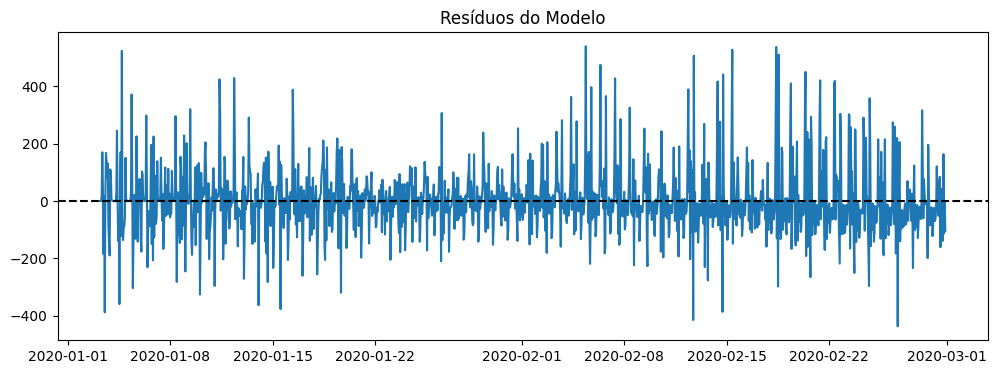

In [51]:
plt.figure(figsize=(12,4))
plt.plot(residuos)
plt.title("Resíduos do Modelo")
plt.axhline(0, color="black", linestyle="--")
plt.show()

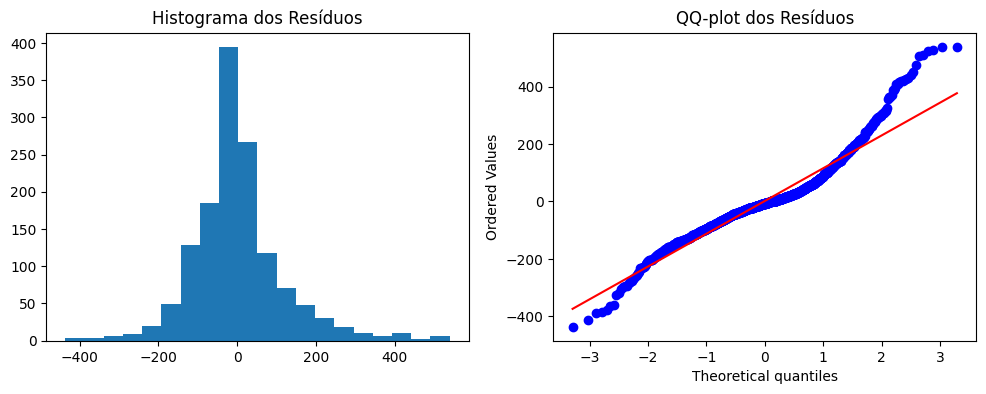

In [52]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(residuos, bins=20)
plt.title("Histograma dos Resíduos")
plt.subplot(1,2,2)
stats.probplot(residuos, dist="norm", plot=plt)  # QQ-plot
plt.title("QQ-plot dos Resíduos")
plt.show()

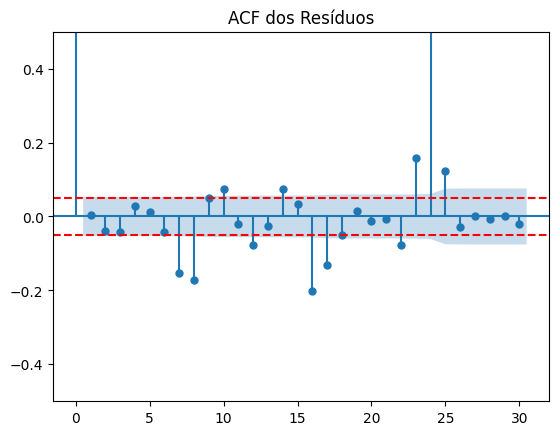

In [53]:
plot_acf(residuos, lags=30)
plt.title("ACF dos Resíduos")

plt.ylim(-0.5, 0.5)

plt.axhline(y=0.05, color='red', linestyle='--')
plt.axhline(y=-0.05, color='red', linestyle='--')

plt.show()

In [54]:
lb_test = acorr_ljungbox(residuos, lags=[10, 15, 20], return_df=True)
print("Ljung-Box test (estatística e p-valor por lag):")
print(lb_test)

Ljung-Box test (estatística e p-valor por lag):
       lb_stat     lb_pvalue
10   93.834355  9.269324e-16
15  113.401733  3.573827e-17
20  199.634553  1.329140e-31


In [56]:
# Dividir em treino / validação / teste (50% / 25% / 25%)
def split_series(serie):
    n = len(serie)
    n_train = int(0.5 * n)
    n_val   = int(0.25 * n)
    train = serie.iloc[:n_train]
    val   = serie.iloc[n_train:n_train+n_val]
    test  = serie.iloc[n_train+n_val:]
    return train, val, test

serie = dataset["Production"].astype(float)
train, val, test = split_series(serie)
print(len(train), len(val), len(test))


719 359 361


In [ ]:
# 2. Buscar melhor ARIMA/SARIMA nos dados de treino
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

def mape(y_true, y_pred, eps=1e-9):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def fit_and_forecast(train, val, order, seasonal_order):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    preds = res.get_forecast(steps=len(val)).predicted_mean
    return preds, res

pqs = range(0,2)  # p,q até 1
ds  = [0,1]
PQs = range(0,2)
Ds  = [0,1]
s   = 168  # sazonalidade semanal (168 horas)

melhor = None
for p in pqs:
    for d in ds:
        for q in pqs:
            for P in PQs:
                for D in Ds:
                    for Q in PQs:
                        try:
                            preds, res = fit_and_forecast(train, val, (p,d,q), (P,D,Q,s))
                            mse = np.mean((val.values - preds.values)**2)
                            mp  = mape(val.values, preds.values)
                            if (melhor is None) or (mse < melhor["mse"]):
                                melhor = {"order": (p,d,q),
                                          "seasonal": (P,D,Q,s),
                                          "mse": mse, "mape": mp, "res": res}
                            print(f"ARIMA{(p,d,q)}x{(P,D,Q,s)} -> MSE={mse:.2f}, MAPE={mp:.2f}%")
                        except:
                            continue

print("Melhor modelo:", melhor)

ARIMA(0, 0, 0)x(0, 0, 0, 168) -> MSE=883639.33, MAPE=47.35%


In [ ]:
# 3. Avaliar no conjunto de teste
trainval = pd.concat([train, val])
res_final = SARIMAX(trainval,
                    order=melhor["order"],
                    seasonal_order=melhor["seasonal"],
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit(disp=False)

preds_test = res_final.get_forecast(steps=len(test)).predicted_mean
mse_test = np.mean((test.values - preds_test.values)**2)
mape_test = mape(test.values, preds_test.values)

print(f"Teste -> MSE={mse_test:.2f}, MAPE={mape_test:.2f}%")

In [ ]:
# 4. Gráficos de comparação
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(train.index, train, label="Treino")
plt.plot(val.index, val, label="Validação")
plt.plot(test.index, test, label="Teste")
plt.plot(preds_test.index, preds_test, label="Previsto (Teste)", color="red")
plt.legend()
plt.title(f"SARIMA {melhor['order']} x {melhor['seasonal']}")
plt.show()